In [25]:
!pip install koreanize-matplotlib
import koreanize_matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: C:\Users\HOME\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


#### 시드(seed) 고정  

In [27]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#### 데이터 읽어오기 및 데이터 확인

In [28]:
train = pd.read_csv('C:/Users/HOME/Downloads/범죄분류데이터/train.csv')

train.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


#### 독립변수(x_train), 종속변수(y_train)로 분리하기  


In [29]:
x_train = train.drop(['ID', 'TARGET'], axis = 1)
y_train = train['TARGET']


In [30]:
x_train.head()

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
1,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
2,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도
3,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지
4,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소


#### train , validation data 나누기

In [31]:
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#### 라벨인코딩(Label Encoding) 

In [32]:

ordinal_features = ['요일', '범죄발생지']

for feature in ordinal_features:
    le = LabelEncoder()
    
    # Fit and transform on the training data
    le = le.fit(X_tr[feature])
    X_tr[feature] = le.transform(X_tr[feature])

    # Transform the test data (Note: Only transform, do not fit again to avoid data leakage)
    X_val[feature] = le.transform(X_val[feature])



In [33]:
X_tr.head()

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
45887,9,2,12,1140,31.0,1.792490,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10
64986,3,5,6,738,27.0,0.771010,0.0,0.0,0.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
12545,5,1,3,1749,46.0,1.962962,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
19141,6,0,10,1749,46.0,2.356086,0.0,0.0,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
70002,3,5,7,737,27.0,0.882831,0.0,0.0,0.0,285.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


#### 모델 정의

In [34]:
# 모델 인자에 random_state를 넣음으로써 시드고정의 효과를 얻을 수 있습니다.
rf_model = RandomForestClassifier(random_state=42)

#### 모델 학습

In [35]:
rf_model.fit(X_tr, Y_tr)

RandomForestClassifier(random_state=42)

#### 예측

In [36]:
pred = rf_model.predict(X_val)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, pred)
print('Confusion Matrix:')
print(conf_matrix)

정확도 : 0.5295
정말도 : 0.5215
Recall: 0.5295
F1 Score: 0.5190
Confusion Matrix:
[[5104 1095 1092]
 [1977 2342  816]
 [2086  877 1493]]


#### model - 하이퍼파라미터 설정 

In [10]:
rf_model = RandomForestClassifier(random_state = 42,max_depth=10, min_samples_leaf=4, n_estimators=100)
rf_model.fit(X_tr, Y_tr)
pred = rf_model.predict(X_val)

In [38]:
import time

In [39]:
# 최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}

start_time = time.time()

best_rf_model = RandomForestClassifier(oob_score=True,random_state = 42,max_depth=10, min_samples_leaf= 4, n_estimators=100)
best_rf_model.fit(X_tr, Y_tr)

end_time = time.time()
training_time = end_time - start_time

print(f"모델 학습 시간: {training_time:.4f} 초")

# 예측
best_pred = best_rf_model.predict(X_val)

모델 학습 시간: 7.5217 초


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,best_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,best_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, best_pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, best_pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, best_pred)
print('Confusion Matrix:')
print(conf_matrix)

정확도 : 0.5483
정말도 : 0.5437
Recall: 0.5483
F1 Score: 0.5374
Confusion Matrix:
[[5335  883 1073]
 [2052 2214  869]
 [1981  768 1707]]


#### OOB score

In [42]:
# 모델 초기화 및 OOB 점수 계산
rf_model_oob = RandomForestClassifier(random_state=42,oob_score=True)
rf_model_oob.fit(X_tr,Y_tr)

# OOB 점수 출력
print("OOB 점수:", rf_model_oob.oob_score_)

OOB 점수: 0.5145429773117707


In [43]:
#best_rf_model

print("OOB 점수:", best_rf_model.oob_score_)

OOB 점수: 0.5418962146792252


#### ExtraTreeClassifier

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

# ExtraTrees 모델 초기화
extra_trees_model = ExtraTreesClassifier(random_state=42)
extra_trees_model.fit(X_tr,Y_tr)

# 예측
pred_extra_trees = extra_trees_model.predict(X_val)

In [18]:

acc=accuracy_score(Y_val,pred_extra_trees)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,pred_extra_trees, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, pred_extra_trees, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, pred_extra_trees, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, pred_extra_trees)
print('Confusion Matrix:')
print(conf_matrix)

정확도 : 0.5116
정말도 : 0.5031
Recall: 0.5116
F1 Score: 0.5031
Confusion Matrix:
[[4829 1252 1210]
 [1920 2360  855]
 [2082  926 1448]]


In [19]:
# 랜덤 포레스트의 피처 중요도
feature_importance_rf = rf_model.feature_importances_

# ExtraTrees의 피처 중요도
feature_importance = rf_model.feature_importances_


In [20]:
feature_importance

array([0.02446027, 0.02190498, 0.03062087, 0.15565624, 0.12638903,
       0.05997983, 0.0247622 , 0.00647105, 0.01005404, 0.03002716,
       0.00434064, 0.00101187, 0.00352061, 0.00134165, 0.00096702,
       0.00435751, 0.00070571, 0.49342933])

In [21]:
import matplotlib.pyplot as plt

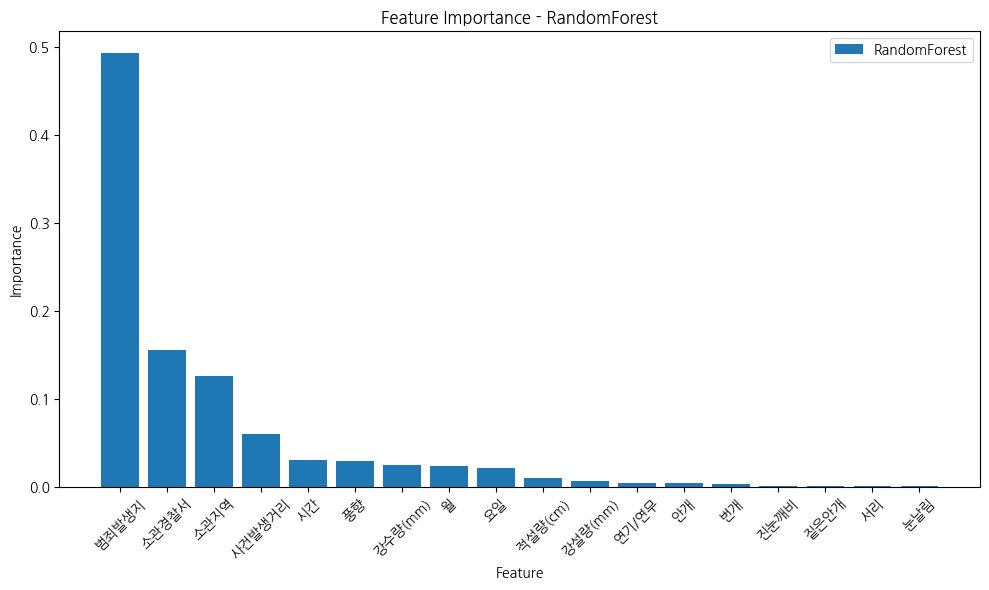

In [22]:
feature_importance_rf = rf_model.feature_importances_

# ExtraTrees 피처 중요도
feature_importance_extra_trees = extra_trees_model.feature_importances_

# 피처 이름 가져오기
feature_names = X_tr.columns


feature_importance_data = {'Feature': feature_names, 'RandomForest': feature_importance_rf, 'ExtraTrees': feature_importance_extra_trees}
feature_importance_df = pd.DataFrame(feature_importance_data)

# 피처 중요도를 내림차순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by=['RandomForest'], ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['RandomForest'], align='center', label='RandomForest')
plt.xticks(range(len(feature_importance_df)), feature_importance_df['Feature'], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - RandomForest')
plt.legend()
plt.tight_layout()
plt.show()

#### RFE 

In [44]:
from sklearn.feature_selection import RFE

In [24]:
for n_features in range(1, 17):
    # RFE를 사용하여 특성 선택
    rfe = RFE(estimator=best_rf_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_tr, Y_tr)
    X_test_rfe = rfe.transform(X_val)

    # 모델 훈련 및 예측
    rf_model.fit(X_train_rfe, Y_tr)
    y_pred_rf = rf_model.predict(X_test_rfe)

    # 정확도 출력
    accuracy_rf = accuracy_score(Y_val, y_pred_rf)
    print(f'n_features_to_select={n_features}, Accuracy: {accuracy_rf:.2f}')

n_features_to_select=1, Accuracy: 0.53
n_features_to_select=2, Accuracy: 0.56
n_features_to_select=3, Accuracy: 0.56
n_features_to_select=4, Accuracy: 0.56
n_features_to_select=5, Accuracy: 0.56
n_features_to_select=6, Accuracy: 0.55
n_features_to_select=7, Accuracy: 0.55
n_features_to_select=8, Accuracy: 0.55
n_features_to_select=9, Accuracy: 0.55
n_features_to_select=10, Accuracy: 0.55
n_features_to_select=11, Accuracy: 0.55
n_features_to_select=12, Accuracy: 0.55
n_features_to_select=13, Accuracy: 0.55
n_features_to_select=14, Accuracy: 0.55
n_features_to_select=15, Accuracy: 0.55
n_features_to_select=16, Accuracy: 0.55


In [46]:

for n_features in range(2, 6):
    # RFE를 사용하여 특성 선택
    rfe = RFE(estimator=best_rf_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_tr, Y_tr)
    X_test_rfe = rfe.transform(X_val)

    # Measure training time
    start_time = time.time()

    # 모델 훈련 및 예측
    rf_model.fit(X_train_rfe, Y_tr)
    y_pred_rf = rf_model.predict(X_test_rfe)

    end_time = time.time()
    training_time = end_time - start_time

    # Get selected features
    selected_features = X_tr.columns[rfe.support_]

    # 정확도 출력, 학습 시간 출력, 선택된 특성 출력
    accuracy_rf = accuracy_score(Y_val, y_pred_rf)
    print(f'n_features_to_select={n_features}, Accuracy: {accuracy_rf:.3f}, Training Time: {training_time:.3f} seconds, Selected Features: {selected_features}')

n_features_to_select=2, Accuracy: 0.553, Training Time: 3.881 seconds, Selected Features: Index(['소관경찰서', '범죄발생지'], dtype='object')
n_features_to_select=3, Accuracy: 0.550, Training Time: 4.190 seconds, Selected Features: Index(['소관경찰서', '소관지역', '범죄발생지'], dtype='object')
n_features_to_select=4, Accuracy: 0.483, Training Time: 17.047 seconds, Selected Features: Index(['소관경찰서', '소관지역', '사건발생거리', '범죄발생지'], dtype='object')
n_features_to_select=5, Accuracy: 0.498, Training Time: 17.328 seconds, Selected Features: Index(['소관경찰서', '소관지역', '사건발생거리', '풍향', '범죄발생지'], dtype='object')


In [47]:

for n_features in range(1, 15):
    # RFE를 사용하여 특성 선택
    rfe = RFE(estimator=best_rf_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_tr, Y_tr)
    X_test_rfe = rfe.transform(X_val)

    # Measure training time
    start_time = time.time()

    # 모델 훈련 및 예측
    rf_model.fit(X_train_rfe, Y_tr)
    y_pred_rf = rf_model.predict(X_test_rfe)

    end_time = time.time()
    training_time = end_time - start_time

    # Get selected features
    selected_features = X_tr.columns[rfe.support_]

    # 정확도 출력, 학습 시간 출력, 선택된 특성 출력
    accuracy_rf = accuracy_score(Y_val, y_pred_rf)
    print(f'n_features_to_select={n_features}, Accuracy: {accuracy_rf:.3f}, Training Time: {training_time:.3f} seconds, Selected Features: {selected_features}')

n_features_to_select=1, Accuracy: 0.530, Training Time: 1.401 seconds, Selected Features: Index(['범죄발생지'], dtype='object')
n_features_to_select=2, Accuracy: 0.553, Training Time: 3.839 seconds, Selected Features: Index(['소관경찰서', '범죄발생지'], dtype='object')
n_features_to_select=3, Accuracy: 0.550, Training Time: 3.997 seconds, Selected Features: Index(['소관경찰서', '소관지역', '범죄발생지'], dtype='object')
n_features_to_select=4, Accuracy: 0.483, Training Time: 16.844 seconds, Selected Features: Index(['소관경찰서', '소관지역', '사건발생거리', '범죄발생지'], dtype='object')
n_features_to_select=5, Accuracy: 0.498, Training Time: 17.481 seconds, Selected Features: Index(['소관경찰서', '소관지역', '사건발생거리', '풍향', '범죄발생지'], dtype='object')
n_features_to_select=6, Accuracy: 0.515, Training Time: 18.248 seconds, Selected Features: Index(['소관경찰서', '소관지역', '사건발생거리', '강수량(mm)', '풍향', '범죄발생지'], dtype='object')
n_features_to_select=7, Accuracy: 0.526, Training Time: 16.655 seconds, Selected Features: Index(['시간', '소관경찰서', '소관지역', '사건발생거리'